In [32]:
from dotenv import load_dotenv
import random
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
import os
import requests
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display,Image
from langgraph.graph import add_messages
from langgraph.graph import StateGraph
from langgraph.graph import START,END
from pydantic import BaseModel
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langsmith import Client
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import WebBaseLoader
import faiss
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.tools import WikipediaQueryRun,ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from typing import List,Annotated

In [22]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
from langchain_groq import ChatGroq
model = ChatGroq(model="llama-3.3-70b-versatile")

In [23]:
import nest_asyncio
nest_asyncio.apply()

In [24]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

# If you get a NotImplementedError here or later, see the Heads Up at the top of the notebook

async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [25]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Abhin\AppData\Local\ms-playwright\chromium-1187\chrome-win\chrome.exe> version=140.0.7339.16>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Abhin\AppData\Local\ms-playwright\chromium-1187\chrome-win\chrome.exe> version=140.0.7339.16>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Abhin\AppData\Local\ms-playwright\chromium-1187\chrome-win\chrome.exe> version=140.0.7339.16>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Abhin\AppData\Local\ms-playwright\chromium-1187\chrome-win\chrome.exe> version=140.0.7339.16>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Abhin\AppData\Local\ms-playwright\chromium-1187\chrome-win\chrome.exe> version=140.0.7339.16>
get_elements=async_browser=<Browser type=<BrowserT

In [26]:
tool_dict = {tool.name:tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

    
await navigate_tool.arun({"url": "https://www.cnn.com"})
text = await extract_text_tool.arun({})

In [27]:
import textwrap
print(textwrap.fill(text))

Breaking News, Latest News and Videos | CNN CNN values your feedback
1. How relevant is this ad to you? 2. Did you encounter any technical
issues? No Video player was slow to load content Video content never
loaded Ad froze or did not finish loading Video content did not start
after ad Audio on ad was too loud Other issues Ad never loaded Ad
prevented/slowed the page from loading Content moved around while ad
loaded Ad was repetitive to ads I've seen previously Other issues
Cancel Submit Thank You! Your effort and contribution in providing
this feedback is much
appreciated. Close Ad Feedback Close icon US World Politics Business
Health Entertainment Style Travel Sports Science Climate Weather
Ukraine-Russia War Israel-Hamas War Games More US World Politics
Business Health Entertainment Style Travel Sports Science Climate
Weather Ukraine-Russia War Israel-Hamas War Games Watch Listen Live TV
Subscribe Sign in My Account Settings Newsletters Topics you follow
Sign out Your CNN account Si

In [28]:
all_tools = tools + [wikipedia,arxiv]

In [29]:
from typing import TypedDict


class State(TypedDict):
    messages:Annotated[List,add_messages]
graph_builder = StateGraph(State)


In [30]:
llm_with_tools = model.bind_tools(all_tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

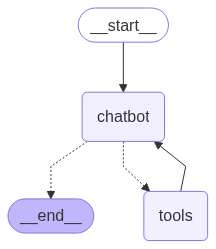

In [33]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Future exception was never retrieved
future: <Future finished exception=Error('net::ERR_ABORTED at https://www.cnn.com/\nCall log:\n  - navigating to "https://www.cnn.com/", waiting until "load"\n')>
playwright._impl._errors.Error: net::ERR_ABORTED at https://www.cnn.com/
Call log:
  - navigating to "https://www.cnn.com/", waiting until "load"

Future exception was never retrieved
future: <Future finished exception=Error('Unable to retrieve content because the page is navigating and changing the content.')>
playwright._impl._errors.Error: Unable to retrieve content because the page is navigating and changing the content.
Future exception was never retrieved
future: <Future finished exception=Error('Unable to retrieve content because the page is navigating and changing the content.')>
playwright._impl._errors.Error: Unable to retrieve content because the page is navigating and changing the content.
Future exception was never retrieved
future: <Future finished exception=Error('net::ERR_A